In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pygsp as pg
from pygsp import graphs, plotting
import cvxpy as cp
import scipy.sparse as s
from scipy.spatial.distance import cdist
import pandas as pd
import cv2
from PIL import Image
import time

plotting.BACKEND = 'matplotlib'
plt.rcParams['figure.figsize'] = (10, 5)

def computeMainSignal(signals,k,N):
    x = np.zeros((N,1))
    for i in range(k):
        x = x + signals[:,i].reshape(N,1)
    return x

def decomposeGraphSignal(mainSignal,graphs,k,N):   
    # Create A , H
    w = np.arange(1,40*(N-1),40)
    H = np.diag(np.tile(w, (1, k))[0])
    for i in range(k):
        G = graphs[i]
        A_init = G.U[:N, 1:]
        if i==0:
            A = A_init
        else:
            A = np.hstack((A, A_init))

    # solve by CVX
    Y = cp.Variable(((N-1)*k,1))
    objective = cp.Minimize(cp.quad_form(Y, H))  
    # equality 
    constraints = [A @ Y == mainSignal]
    prob = cp.Problem(objective, constraints)
    result = prob.solve(verbose=True)
    Y_hat = np.vstack((np.zeros((1,k)),Y.value.reshape(N-1,k,order='F')))

    # IGFT
    X_hat = np.zeros((N,k))
    for i in range(k):
        G = graphs[i]
        X_hat[:,i] = (G.U @ Y_hat[:,i])
    
    return X_hat

def connected_adjacency(r, c, connect):
    """
    Creates an adjacency matrix from an image where nodes are considered adjacent 
    based on 4-connected or 8-connected pixel neighborhoods.

    :return: adjacency matrix as a sparse matrix (type=scipy.sparse.csr.csr_matrix)
    """

    if connect == '4':
        d1 = np.tile(np.append(np.ones(c-1), [0]), r)[:-1]
        d2 = np.ones(c*(r-1))
        upper_diags = s.diags([d1, d2], [1, c])
        return upper_diags + upper_diags.T

    elif connect == '8':
        d1 = np.tile(np.append(np.ones(c-1), [0]), r)[:-1]
        d2 = np.append([0], d1[:c*(r-1)])
        d3 = np.ones(c*(r-1))
        d4 = d2[1:-1]
        upper_diags = s.diags([d1, d2, d3, d4], [1, c-1, c, c+1])
        return upper_diags + upper_diags.T
    else:
        raise ValueError('Invalid parameter \'connect\'={connect}, must be "4" or "8".'
                     .format(connect=repr(connect)))


def computeSmoothness(signals,graphs,k):
    smoothness = []
    sumOverSmoothness = 0
    for i in range(k):
        smoothness.append(signals[:,i].T@graphs[i].L@signals[:,i])
        sumOverSmoothness = sumOverSmoothness + smoothness[i]
    return sumOverSmoothness,smoothness

def calculateSNR(est_signals,signals,k):
    SNR = []
    for i in range(k):
        SNR.append(10*np.log10(np.linalg.norm(signals[:,i])**2/np.linalg.norm(signals[:,i]-est_signals[:,i])**2))
    return SNR

def compareSignals(estimated_signals,signals,k,N):
    for i in range(k):
        plt.plot(range(1,N+1),signals[:,i], label = "original", marker='o')
        plt.plot(range(1,N+1),estimated_signals[:,i], linestyle='dashed', label = "estimated", marker='o')
        plt.title('graph signal '+str(i+1)+' ,number of layers = '+str(k))
        plt.legend(loc ="upper right")
        #plt.savefig('S_plot'+str(i+1)+'_L'+str(k)+'.png', dpi=300, bbox_inches='tight')
        plt.show()
        
def writeEstimatedImages(estimated_signals,k,N,r,c,saveMode):        
    for i in range(k): 
        est = estimated_signals[:,i].astype(np.uint8)
        est = est.reshape((r,c))
        cv2.imwrite('est_bird'+str(i+1)+saveMode+'.jpeg', est)
        
def scaleSignal(signal):
    # scale original images between 0-255
    signal = 255/(max(signal)-min(signal))*(signal-min(signal))
    
    return signal
        
def scaleResult(signal):
    # shift esimated signals between 0-255 in order to avoid overflow to save estimated images
    u = signal+127
    u[u>255] = 255
    u[u<0] = 0
    return u

In [11]:
# load images and create graph signals
t1 = time.time()
dim = 64
r = dim    # number of rows
c = dim    # number of columns
N = r*c   # number of nodes
k = 2     # number of graphs

img1 = cv2.imread('bird/bird1.jpg') 
img2 = cv2.imread('bird/bird2.jpg') 
  
gray_img1 = np.float64(cv2.cvtColor(img1[:r,:c], cv2.COLOR_BGR2GRAY))
gray_img2 = np.float64(cv2.cvtColor(img2[:r,:c], cv2.COLOR_BGR2GRAY) )

# scale original images between 0-255
graphSignal1 = scaleSignal(gray_img1.reshape((N,1))) 
graphSignal2 = scaleSignal(gray_img2.reshape((N,1)))

mixed = (graphSignal1+graphSignal2)/2.
#cv2.imwrite('bird/mixed.jpeg', mixed.astype(np.uint8).reshape((r,c)))

print('mean1:',np.mean(graphSignal1))
print('mean2:',np.mean(graphSignal2))

mean1: 125.19174429086536
mean2: 111.49391732564787


In [12]:
# create a binary adjacency matrix for a 8-connected graph
W_raw = connected_adjacency(r, c, '8')

# create adjacency matrices (setting weight for non-zero edges of W_raw)
W1 = s.csc_matrix(W_raw.toarray() * (1/(cdist(graphSignal1, graphSignal1)+0.001)))
W2 = s.csc_matrix(W_raw.toarray() * (1/(cdist(graphSignal2, graphSignal2)+0.001)))

# create graphs
graph_list = []
 
graph_list.append(graphs.Graph(W1))
graph_list.append(graphs.Graph(W2))

graph_list[0].compute_fourier_basis()
graph_list[1].compute_fourier_basis()

print('** fourier basis is computed. **')

#subtracting DC values from the original signals 
#for further computations and comparisons
signals = np.zeros((N,k))
signals[:,[0]] = graphSignal1-np.mean(graphSignal1)
signals[:,[1]] = graphSignal2-np.mean(graphSignal2)

# mix signals
mainSignal = computeMainSignal(signals,k,N)

2021-11-24 14:39:55,264:[WARNING](pygsp.graphs.graph.compute_fourier_basis): Computing the full eigendecomposition of a large matrix (4096 x 4096) may take some time.
2021-11-24 14:40:18,165:[WARNING](pygsp.graphs.graph.compute_fourier_basis): Computing the full eigendecomposition of a large matrix (4096 x 4096) may take some time.


** fourier basis computed. **


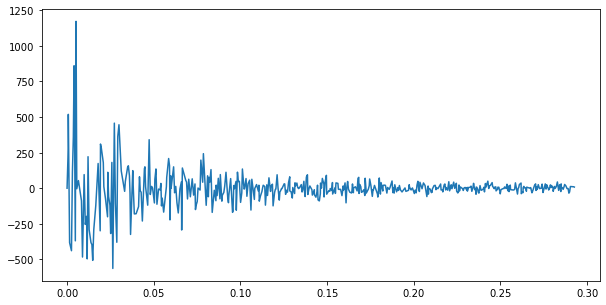

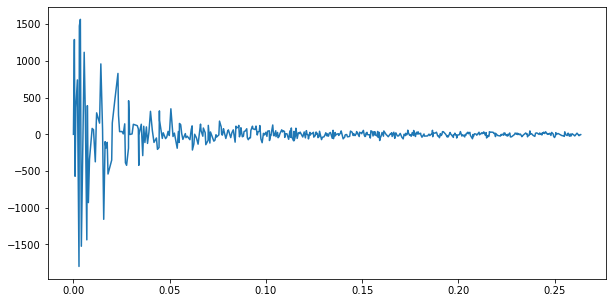

In [13]:
# GFT
GFT1 = graph_list[0].U.T@signals[:,[0]]
E1 = graph_list[0].e
plt.plot(E1[:500],GFT1[:500])
plt.show()
GFT2 = graph_list[1].U.T@signals[:,[1]]
E2 = graph_list[1].e
plt.plot(E2[:500],GFT2[:500])
plt.show()
output_df1 = pd.DataFrame({'x': E1[:500],'y': GFT1[:500,0]})  
#output_df1.to_csv('gft_bird1.dat')
output_df2 = pd.DataFrame({'x': E2[:500],'y': GFT2[:500,0]})  
#output_df2.to_csv('gft_bird2.dat')

In [14]:
# decompose
estimated_signals = decomposeGraphSignal(mainSignal,graph_list,k,N)
t2 = time.time()
print('time:',t2-t1)

-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 8190, constraints m = 4096
          nnz(P) + nnz(A) = 33544682
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   2.67e+02   6.38e+09   1.00e-01   8.72e+01s
  50   2.6901e+10   3.97e-07   8.60e-02   1.00e-01   9.29e+01s
plsh   2.6901e+10   1.30e-08   1.76e-0

SNR: [9.07200268000928, 13.865701300158982]
error: 2.552951323466756e-07


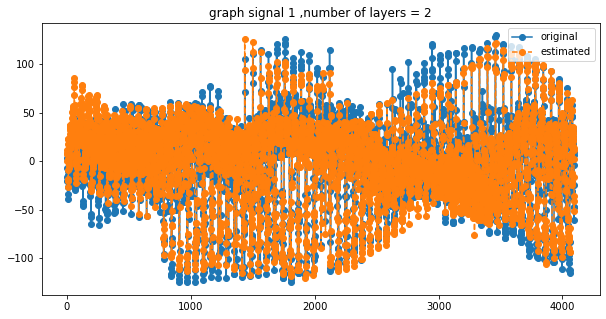

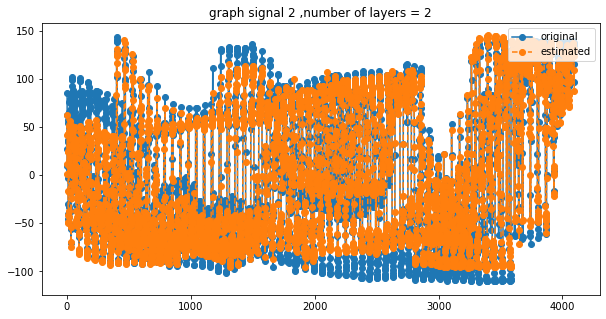

SNRs after shifting estimated signals between 0-255 and cropping values outside [0-255]:
[18.628451386260338, 15.876458268227644]


In [15]:
# calculate SNRs
SNRs = calculateSNR(estimated_signals,signals,k)
print('SNR:',SNRs)

# compute error
error = np.linalg.norm(mainSignal-estimated_signals@np.ones((k,1)))
print('error:',error)

# compare estimated signals with the originals
compareSignals(estimated_signals,signals,k,N)

#******************************************************************
# to save estimated images their values should be between 0-255
scaled_estimated_signals = np.zeros((k,N))
scaled_estimated_signals[[0],:] = scaleResult(estimated_signals[:,0])
scaled_estimated_signals[[1],:] = scaleResult(estimated_signals[:,1])

# write scaled estimated images
writeEstimatedImages(scaled_estimated_signals.T,k,N,r,c,'')